In [1]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import os
import imageio
from PIL import Image
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from tensorflow.keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [5]:


project_folder =  '/datasets/Project_data/'


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [8]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=cv2.resize(image,(self.image_height,self.image_width))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
        

    
    
    

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [9]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

2024-07-03 03:08:57.526144: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-03 03:08:57.526234: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:41:00.0, compute capability: 7.5


##### Sample Cropping

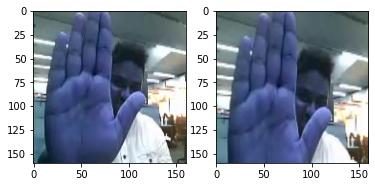

In [11]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with Image resolution, number of frames to use and batch_size

In [12]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [13]:
#conv_3d1=ModelConv3D1()
#conv_3d1.initialize_path(project_folder)
#conv_3d1.initialize_image_properties(image_height=100,image_width=100)
#conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=30,num_epochs=2)
#conv_3d1_model=conv_3d1.define_model()
#print("Total Params:", conv_3d1_model.count_params())
#conv_3d1.train_model(conv_3d1_model)

In [14]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 892101
Epoch 1/2


2024-07-03 03:09:58.688438: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.6197 - categorical_accuracy: 0.4027
Epoch 00001: val_loss improved from inf to 1.65425, saving model to model_init_2024-07-0303_09_55.178002/model-00001-1.61969-0.40271-1.65425-0.27000.h5
34/34 [==============================] - 49s 1s/step - loss: 1.6197 - categorical_accuracy: 0.4027 - val_loss: 1.6543 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/2
34/34 [==============================] - ETA: 0s - loss: 1.1817 - categorical_accuracy: 0.5430
Epoch 00002: val_loss did not improve from 1.65425
34/34 [==============================] - 44s 1s/step - loss: 1.1817 - categorical_accuracy: 0.5430 - val_loss: 2.3933 - val_categorical_accuracy: 0.1700 - lr: 0.0010


In [15]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1940677
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5815 - categorical_accuracy: 0.4042
Epoch 00001: val_loss improved from inf to 1.72347, saving model to model_init_2024-07-0303_11_29.091564/model-00001-1.58147-0.40422-1.72347-0.22000.h5
45/45 [==============================] - 60s 1s/step - loss: 1.5815 - categorical_accuracy: 0.4042 - val_loss: 1.7235 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.1041 - categorical_accuracy: 0.5701
Epoch 00002: val_loss did not improve from 1.72347
45/45 [==============================] - 57s 1s/step - loss: 1.1041 - categorical_accuracy: 0.5701 - val_loss: 3.2176 - val_categorical_accuracy: 0.1900 - lr: 0.0010


In [16]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1940677
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.6374 - categorical_accuracy: 0.4027
Epoch 00001: val_loss improved from inf to 2.51879, saving model to model_init_2024-07-0303_13_27.752396/model-00001-1.63744-0.40271-2.51879-0.16000.h5
23/23 [==============================] - 33s 1s/step - loss: 1.6374 - categorical_accuracy: 0.4027 - val_loss: 2.5188 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.2532 - categorical_accuracy: 0.5264
Epoch 00002: val_loss did not improve from 2.51879
23/23 [==============================] - 30s 1s/step - loss: 1.2532 - categorical_accuracy: 0.5264 - val_loss: 2.9499 - val_categorical_accuracy: 0.2200 - lr: 0.0010


- As we see from the above experiments **"image resolution"** and **number of frames** in sequence have more impact on training time than **batch_size**
- We can consider the Batch Size around 15-40
- We will change the resoulution 160*160, 120*120 according the model performance


## Model 1
### Base Model - Batch Size = 40 and No. of Epochs = 15

In [17]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [18]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_17 (Activation)  (None, 10, 80, 80, 32)   

In [19]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.6067 - categorical_accuracy: 0.4012
Epoch 00001: val_loss improved from inf to 1.63891, saving model to model_init_2024-07-0303_14_32.266563/model-00001-1.60666-0.40121-1.63891-0.27000.h5
17/17 [==============================] - 42s 2s/step - loss: 1.6067 - categorical_accuracy: 0.4012 - val_loss: 1.6389 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.0447 - categorical_accuracy: 0.6018
Epoch 00002: val_loss did not improve from 1.63891
17/17 [==============================] - 38s 2s/step - loss: 1.0447 - categorical_accuracy: 0.6018 - val_loss: 2.3339 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.8654 - categorical_accuracy: 0.6682
Epoch 00003: val_loss did not improve from 1.63891
17/17 [==============================] - 37s 2s/step - loss: 0.8654 - cate

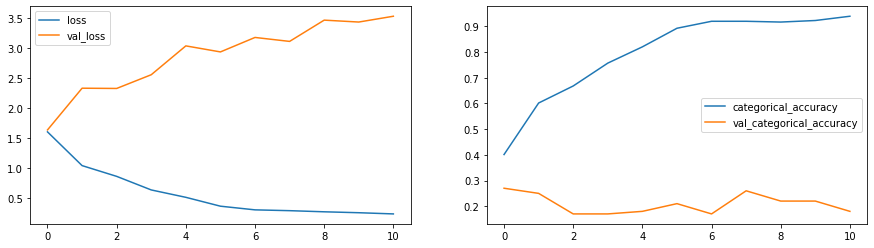

In [20]:
plot(history_model1)

## Model 2  
### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [21]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_21 (Activation)  (None, 10, 80, 80, 32)   

In [22]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8992 - categorical_accuracy: 0.3906
Epoch 00001: val_loss improved from inf to 5.28296, saving model to model_init_2024-07-0303_21_27.716930/model-00001-1.89922-0.39065-5.28296-0.16000.h5
34/34 [==============================] - 82s 2s/step - loss: 1.8992 - categorical_accuracy: 0.3906 - val_loss: 5.2830 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4975 - categorical_accuracy: 0.4977
Epoch 00002: val_loss did not improve from 5.28296
34/34 [==============================] - 80s 2s/step - loss: 1.4975 - categorical_accuracy: 0.4977 - val_loss: 7.6088 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3791 - categorical_accuracy: 0.5362
Epoch 00003: val_loss did not improve from 5.28296
34/34 [==============================] - 83s 2s/step - loss: 1.3791 - cate

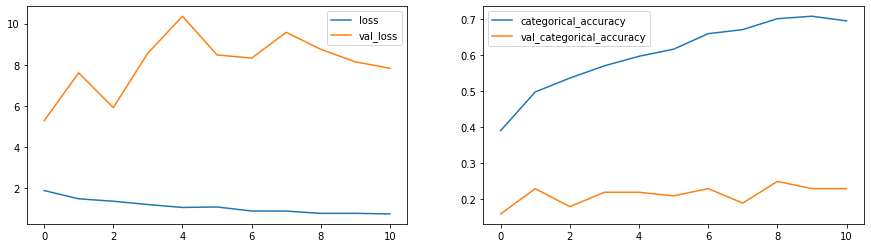

In [23]:
plot(history_model2)

##### We can see  val_loss did not improve so earlystopping stops the epoch automatically!! 
- Last Epoch stop on 11/25
- Best weights save automatically. The validation accuracy of 23% and training accuracy of 69%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

## Model 3 
### Reduce filter size to (2,2,2) and image res to 120 x  120, - Batch Size = 30 and No. of Epochs = 25

In [24]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_24 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_36 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_25 (Activation)  (None, 8, 60, 60, 32)    

In [26]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.2108 - categorical_accuracy: 0.3137
Epoch 00001: val_loss improved from inf to 1.90977, saving model to model_init_2024-07-0303_36_40.562512/model-00001-2.21084-0.31373-1.90977-0.21000.h5
23/23 [==============================] - 56s 2s/step - loss: 2.2108 - categorical_accuracy: 0.3137 - val_loss: 1.9098 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
22/23 [===========================>..] - ETA: 2s - loss: 1.5194 - categorical_accuracy: 0.4864
Epoch 00002: val_loss did not improve from 1.90977
23/23 [==============================] - 54s 2s/step - loss: 1.5201 - categorical_accuracy: 0.4864 - val_loss: 2.8403 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
22/23 [===========================>..] - ETA: 2s - loss: 1.3196 - categorical_accuracy: 0.5394
Epoch 00003: val_loss did not improve from 1.90977
23/23 [==============================] - 55s 2s/step - loss: 1.327

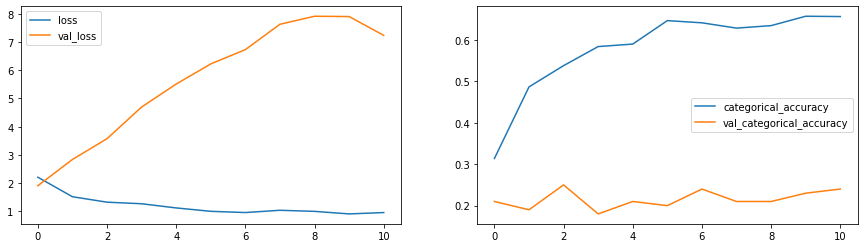

In [27]:
plot(history_model3)

##### Model has a validation accuracy of 24% and training accuracy of 65% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

## Model 4 - 
### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [28]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [29]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_42 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_29 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_29 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_43 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [30]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.1398 - categorical_accuracy: 0.3409
Epoch 00001: val_loss improved from inf to 1.58843, saving model to model_init_2024-07-0303_46_35.934521/model-00001-2.13976-0.34087-1.58843-0.35000.h5
34/34 [==============================] - 61s 2s/step - loss: 2.1398 - categorical_accuracy: 0.3409 - val_loss: 1.5884 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5333 - categorical_accuracy: 0.4842
Epoch 00002: val_loss did not improve from 1.58843
34/34 [==============================] - 56s 2s/step - loss: 1.5333 - categorical_accuracy: 0.4842 - val_loss: 2.8156 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3681 - categorical_accuracy: 0.5075
Epoch 00003: val_loss did not improve from 1.58843
34/34 [==============================] - 55s 2s/step - loss: 1.3681 - cate

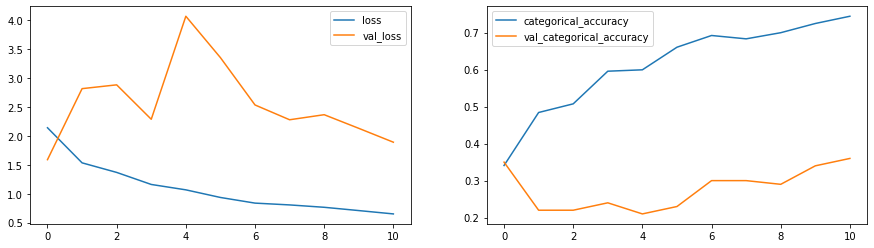

In [31]:
plot(history_model4)

##### With more layers we dont see much performance improvement. We get validation accuracy of 36% . Let's try adding dropouts at the convolution layers

## Model 5 
### Adding dropout at convolution layers

In [32]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [33]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_36 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_52 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_37 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_37 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_53 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [34]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.7218 - categorical_accuracy: 0.4118
Epoch 00001: val_loss improved from inf to 3.24636, saving model to model_init_2024-07-0303_56_53.372826/model-00001-1.72178-0.41176-3.24636-0.18000.h5
34/34 [==============================] - 59s 2s/step - loss: 1.7218 - categorical_accuracy: 0.4118 - val_loss: 3.2464 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.2331 - categorical_accuracy: 0.5362
Epoch 00002: val_loss did not improve from 3.24636
34/34 [==============================] - 55s 2s/step - loss: 1.2331 - categorical_accuracy: 0.5362 - val_loss: 4.2034 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.0685 - categorical_accuracy: 0.5928
Epoch 00003: val_loss did not improve from 3.24636
34/34 [==============================] - 56s 2s/step - loss: 1.0685 - cate

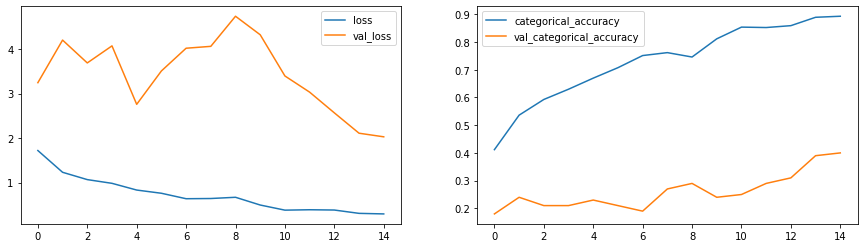

In [35]:
plot(history_model5)

 __Ohh! Overfitting again!! Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.__

##### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## Model 6 
### Reducing the number of parameters

In [36]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [37]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_44 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_62 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_45 (Activation)  (None, 8, 50, 50, 32)    

In [38]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7206 - categorical_accuracy: 0.4020
Epoch 00001: val_loss improved from inf to 2.16649, saving model to model_init_2024-07-0304_10_59.947274/model-00001-1.72059-0.40196-2.16649-0.21000.h5
34/34 [==============================] - 54s 2s/step - loss: 1.7206 - categorical_accuracy: 0.4020 - val_loss: 2.1665 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2074 - categorical_accuracy: 0.5377
Epoch 00002: val_loss did not improve from 2.16649
34/34 [==============================] - 52s 2s/step - loss: 1.2074 - categorical_accuracy: 0.5377 - val_loss: 3.8297 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0150 - categorical_accuracy: 0.6139
Epoch 00003: val_loss did not improve from 2.16649
34/34 [==============================] - 50s 2s/step - loss: 1.0150

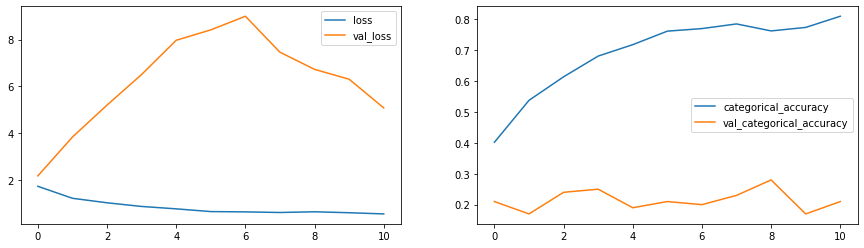

In [39]:
plot(history_model6)

## Model 7 - Reducing the number of parameters again

In [40]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [41]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_48 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_68 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_49 (Activation)  (None, 8, 60, 60, 32)   

In [42]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8959 - categorical_accuracy: 0.3100
Epoch 00001: val_loss improved from inf to 1.75001, saving model to model_init_2024-07-0304_20_22.052779/model-00001-1.89587-0.30995-1.75001-0.16000.h5
34/34 [==============================] - 57s 2s/step - loss: 1.8959 - categorical_accuracy: 0.3100 - val_loss: 1.7500 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3584 - categorical_accuracy: 0.4872
Epoch 00002: val_loss did not improve from 1.75001
34/34 [==============================] - 55s 2s/step - loss: 1.3584 - categorical_accuracy: 0.4872 - val_loss: 2.0485 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/25
33/34 [============================>.] - ETA: 1s - loss: 1.1140 - categorical_accuracy: 0.5674
Epoch 00003: val_loss did not improve from 1.75001
34/34 [==============================] - 52s 2s/step - loss: 1.1177

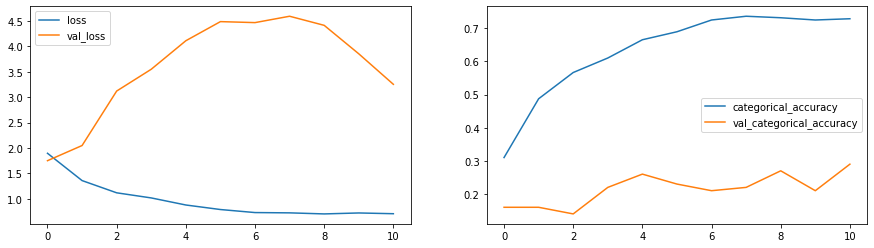

In [43]:
plot(history_model7)

## Model 8 - CNN- LSTM Model

In [44]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [45]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32) 

In [46]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3752 - categorical_accuracy: 0.4087
Epoch 00001: val_loss improved from inf to 1.67453, saving model to model_init_2024-07-0304_30_28.555891/model-00001-1.37525-0.40875-1.67453-0.23000.h5
34/34 [==============================] - 65s 2s/step - loss: 1.3752 - categorical_accuracy: 0.4087 - val_loss: 1.6745 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1318 - categorical_accuracy: 0.5385
Epoch 00002: val_loss did not improve from 1.67453
34/34 [==============================] - 62s 2s/step - loss: 1.1318 - categorical_accuracy: 0.5385 - val_loss: 1.9802 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9980 - categorical_accuracy: 0.6048
Epoch 00003: val_loss did not improve from 1.67453
34/34 [==============================] - 62s 2s/step - loss: 0.9980 - cate

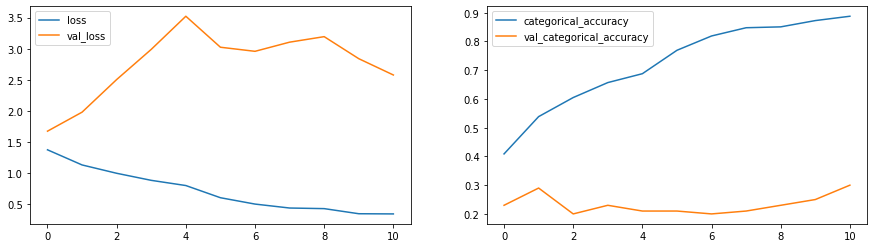

In [47]:
plot(history_model8)

##### For CNN - LSTM model we get validation accuracy of 30%

As we see more cases of overfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Let's apply some data augmentation & check the model performance.

In [7]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=cv2.resize(image,(self.image_height,self.image_width))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    

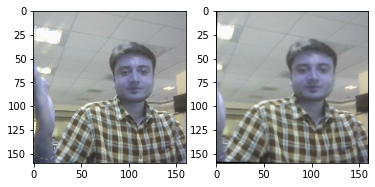

In [8]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

## Model 9 with Augmentation
### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [51]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [52]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_52 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_79 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_53 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_53 (Activation)  (None, 10, 80, 80, 32)  

In [53]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.9361 - categorical_accuracy: 0.3748
Epoch 00001: saving model to model_init_2024-07-0304_49_36.957481/model-00001-1.93605-0.37481-2.31857-0.23000.h5
34/34 [==============================] - 90s 3s/step - loss: 1.9361 - categorical_accuracy: 0.3748 - val_loss: 2.3186 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4871 - categorical_accuracy: 0.5053
Epoch 00002: saving model to model_init_2024-07-0304_49_36.957481/model-00002-1.48706-0.50528-3.59646-0.13000.h5
34/34 [==============================] - 88s 3s/step - loss: 1.4871 - categorical_accuracy: 0.5053 - val_loss: 3.5965 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.2363 - categorical_accuracy: 0.5882
Epoch 00003: saving model to model_init_2024-07-0304_49_36.957481/model-00003-1.23630-0.58824-

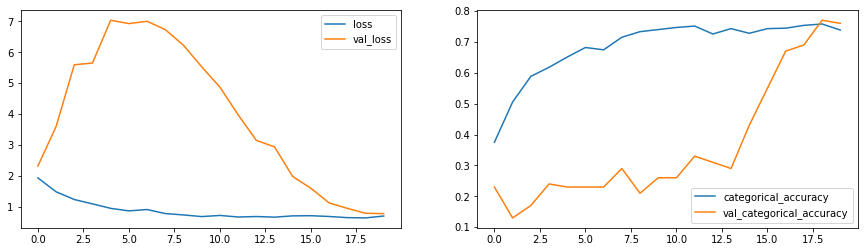

In [ ]:
plot(history_model9)

## Model 10 with Augmentation
### (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [ ]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_68 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_101 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_69 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_69 (Activation)  (None, 8, 60, 60, 32)   

In [ ]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.1212 - categorical_accuracy: 0.3311
Epoch 00001: saving model to model_init_2024-07-0305_18_43.022720/model-00001-2.12124-0.33107-1.90354-0.16000.h5
23/23 [==============================] - 57s 3s/step - loss: 2.1212 - categorical_accuracy: 0.3311 - val_loss: 1.9035 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.5424 - categorical_accuracy: 0.4736
Epoch 00002: saving model to model_init_2024-07-0305_18_43.022720/model-00002-1.54236-0.47360-2.80107-0.18000.h5
23/23 [==============================] - 55s 2s/step - loss: 1.5424 - categorical_accuracy: 0.4736 - val_loss: 2.8011 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/25
22/23 [===========================>..] - ETA: 2s - loss: 1.3138 - categorical_accuracy: 0.5455
Epoch 00003: saving model to model_init_2024-07-0305_18_43.022720/model-00003-1.32448-0.54374-

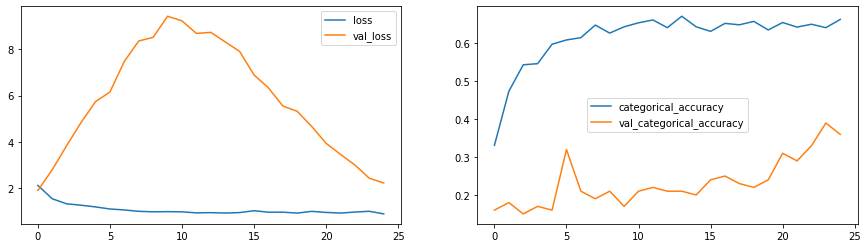

In [ ]:
plot(history_model10)

## Model 11 with Augmentation
### Adding more layers - Similar to model 4

In [ ]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_60 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_91 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_61 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_61 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_92 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                    

In [ ]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.2213 - categorical_accuracy: 0.2994
Epoch 00001: saving model to model_init_2024-07-0305_42_30.086950/model-00001-2.22125-0.29940-1.82832-0.21000.h5
34/34 [==============================] - 59s 2s/step - loss: 2.2213 - categorical_accuracy: 0.2994 - val_loss: 1.8283 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6524 - categorical_accuracy: 0.4510
Epoch 00002: saving model to model_init_2024-07-0305_42_30.086950/model-00002-1.65240-0.45098-2.47904-0.21000.h5
34/34 [==============================] - 58s 2s/step - loss: 1.6524 - categorical_accuracy: 0.4510 - val_loss: 2.4790 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3746 - categorical_accuracy: 0.5189
Epoch 00003: saving model to model_init_2024-07-0305_42_30.086950/model-00003-1.37464-0.51885-

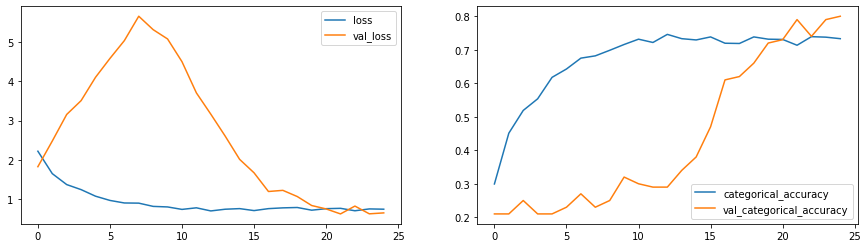

In [ ]:
plot(history_model11)

## Model 12 with Augmentation
### Adding dropouts - Similar to Model 5

In [ ]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_72 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_72 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_107 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_73 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_73 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_108 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [ ]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9719 - categorical_accuracy: 0.3409
Epoch 00001: saving model to model_init_2024-07-0306_06_50.596203/model-00001-1.97189-0.34087-2.10833-0.21000.h5
34/34 [==============================] - 60s 2s/step - loss: 1.9719 - categorical_accuracy: 0.3409 - val_loss: 2.1083 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6594 - categorical_accuracy: 0.4193
Epoch 00002: saving model to model_init_2024-07-0306_06_50.596203/model-00002-1.65939-0.41931-2.99004-0.20000.h5
34/34 [==============================] - 59s 2s/step - loss: 1.6594 - categorical_accuracy: 0.4193 - val_loss: 2.9900 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3748 - categorical_accuracy: 0.4894
Epoch 00003: saving model to model_init_2024-07-0306_06_50.596203/model-00003-1.37479-0.48944-

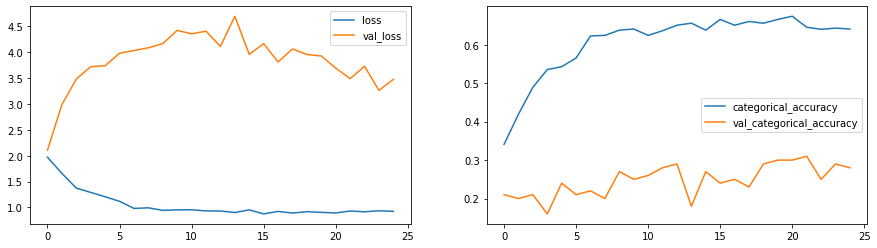

In [ ]:
plot(history_model12)

## Model 13 with Augmentation
### Reducing network parameters - Similar to Model 6

In [ ]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_80 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_80 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_117 (Ba  (None, 16, 100, 100, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_64 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_81 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_81 (Activation)  (None, 8, 50, 50, 32)   

In [ ]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 696645
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8332 - categorical_accuracy: 0.3514
Epoch 00001: saving model to model_init_2024-07-0306_31_47.161214/model-00001-1.83323-0.35143-1.86197-0.21000.h5
34/34 [==============================] - 56s 2s/step - loss: 1.8332 - categorical_accuracy: 0.3514 - val_loss: 1.8620 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2402 - categorical_accuracy: 0.5264
Epoch 00002: saving model to model_init_2024-07-0306_31_47.161214/model-00002-1.24017-0.52640-2.97871-0.17000.h5
34/34 [==============================] - 54s 2s/step - loss: 1.2402 - categorical_accuracy: 0.5264 - val_loss: 2.9787 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/25
33/34 [============================>.] - ETA: 1s - loss: 1.0377 - categorical_accuracy: 0.5970
Epoch 00003: saving model to model_init_2024-07-0306_31_47.161214/model-00003-1.04586-0.59578-3

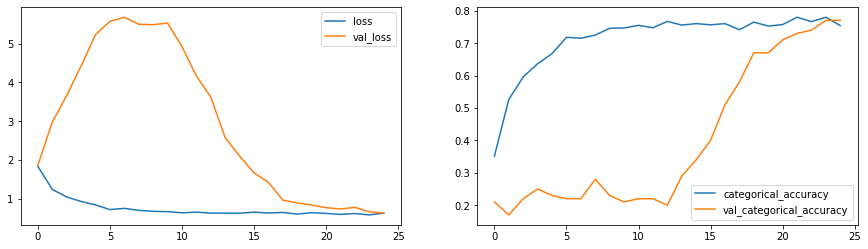

In [ ]:
plot(history_model13)

## Model 14 with Augmentation
###  Reducing network parameters again - Similar to model 7

In [9]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 8, 60, 60, 32)     0

2024-07-03 07:11:01.192162: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-03 07:11:01.192221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


In [11]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/25


2024-07-03 07:11:05.519615: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.7757 - categorical_accuracy: 0.3492
Epoch 00001: saving model to model_init_2024-07-0307_11_01.357890/model-00001-1.77570-0.34917-1.79472-0.18000.h5
34/34 [==============================] - 63s 2s/step - loss: 1.7757 - categorical_accuracy: 0.3492 - val_loss: 1.7947 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2641 - categorical_accuracy: 0.5173
Epoch 00002: saving model to model_init_2024-07-0307_11_01.357890/model-00002-1.26410-0.51735-2.02615-0.24000.h5
34/34 [==============================] - 59s 2s/step - loss: 1.2641 - categorical_accuracy: 0.5173 - val_loss: 2.0262 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0916 - categorical_accuracy: 0.5875
Epoch 00003: saving model to model_init_2024-07-0307_11_01.357890/model-00003-1.09159-0.58748-2.70037-0.19000.h5
34/34 [=======

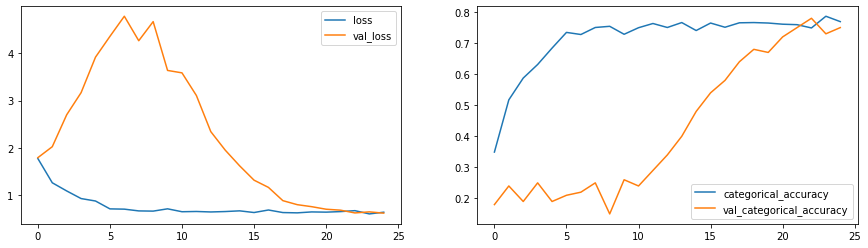

In [12]:
plot(history_model14)

## Model 15 with Augmentation
### CNN LSTM with GRU - Similar to Model 8

In [13]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

In [15]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4127 - categorical_accuracy: 0.3884
Epoch 00001: saving model to model_init_2024-07-0307_36_06.073368/model-00001-1.41268-0.38839-1.62540-0.31000.h5
34/34 [==============================] - 71s 2s/step - loss: 1.4127 - categorical_accuracy: 0.3884 - val_loss: 1.6254 - val_categorical_accuracy: 0.3100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0088 - categorical_accuracy: 0.6086
Epoch 00002: saving model to model_init_2024-07-0307_36_06.073368/model-00002-1.00877-0.60860-1.80657-0.19000.h5
34/34 [==============================] - 71s 2s/step - loss: 1.0088 - categorical_accuracy: 0.6086 - val_loss: 1.8066 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8395 - categorical_accuracy: 0.6885
Epoch 00003: saving model to model_init_2024-07-0307_36_06.073368/model-00003-0.83951-0.68854-

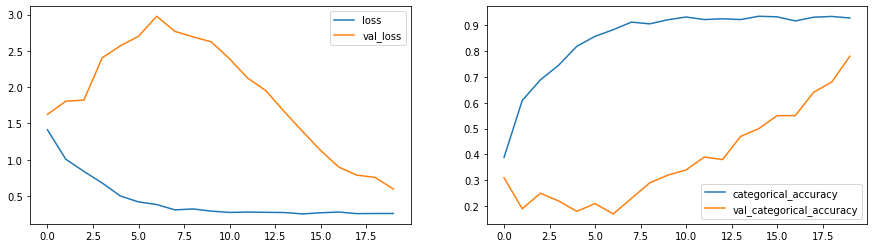

In [16]:
plot(history_model15)

## Model 16 - Let us do Transfer Learning 
__(Optional)__

In [17]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
# in the nimblebox.ai platform. 

from keras.applications import mobilenet

In [18]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)              

In [20]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.4076 - categorical_accuracy: 0.3974
Epoch 00001: saving model to model_init_2024-07-0307_58_45.146630/model-00001-1.40760-0.39744-1.00363-0.70000.h5
133/133 [==============================] - 61s 437ms/step - loss: 1.4076 - categorical_accuracy: 0.3974 - val_loss: 1.0036 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9520 - categorical_accuracy: 0.6214
Epoch 00002: saving model to model_init_2024-07-0307_58_45.146630/model-00002-0.95198-0.62142-0.82948-0.70000.h5
133/133 [==============================] - 57s 429ms/step - loss: 0.9520 - categorical_accuracy: 0.6214 - val_loss: 0.8295 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.7239 - categorical_accuracy: 0.7202
Epoch 00003: saving model to model_init_2024-07-0307_58_45.146630/model-00003-0.72385-

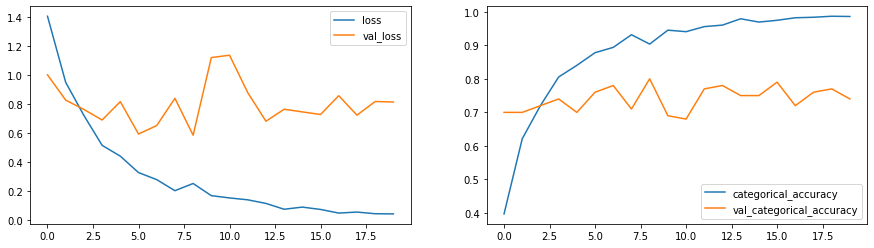

In [21]:
plot(history_model16)

## Model 17 - Transfer Learning with GRU and training all weights
__(Optional)__

In [22]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [24]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.2977 - categorical_accuracy: 0.4729
Epoch 00001: saving model to model_init_2024-07-0308_17_54.645891/model-00001-1.29772-0.47285-0.71184-0.70000.h5
133/133 [==============================] - 63s 441ms/step - loss: 1.2977 - categorical_accuracy: 0.4729 - val_loss: 0.7118 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.7617 - categorical_accuracy: 0.6991
Epoch 00002: saving model to model_init_2024-07-0308_17_54.645891/model-00002-0.76166-0.69910-0.48662-0.76000.h5
133/133 [==============================] - 58s 440ms/step - loss: 0.7617 - categorical_accuracy: 0.6991 - val_loss: 0.4866 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5630 - categorical_accuracy: 0.7926
Epoch 00003: saving model to model_init_2024-07-0308_17_54.645891/model-00003-0.56301-

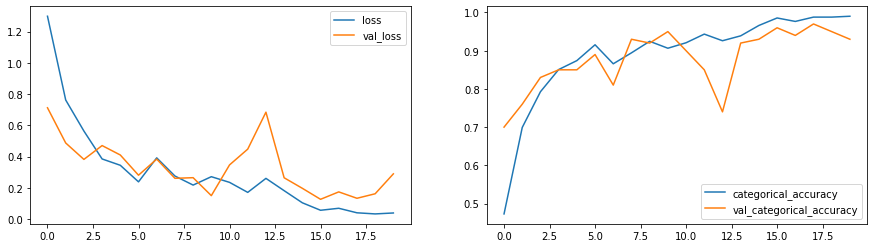

In [25]:
plot(history_model17)

### Awesome results! 98% Training accuracy and 93% validation accuracy :)

# Consolidated Final Models

## After doing all the experiments, we finalized Model 8 - CNN+LSTM, which performed well.
__Reason:__

__- (Training Accuracy : 93%, Validation Accuracy : 85%)__

__- Number of Parameters(1,657,445)less according to other models performance__

__- Learning rate gradually decreacing after 16 Epoch__


__The best weights of CNN-LSTM: model-00020-0.19649-0.93514-0.45695-0.85000.h5 (19 MB). we considered this weight for model testing, Let's have look at the performance below__

# Loading model and Testing

In [26]:
import time
from keras.models import load_model
model = load_model('model_init_2024-07-0308_17_54.645891/model-00020-0.03855-0.99020-0.28899-0.93000.h5')

In [31]:
test_generator=RNNCNN_TL2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [32]:
batch_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [33]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[3 4 3 1 1 1 2 4 2 1 2 4 2 2 3 1 3 4 2 3]


############################################################################################################################
#                                                                                                                          #               
#                                                 Compiled By:                                                             #
#                                                1.Sai Swagath penugonda                                                   #
#                                                                                                                          #
############################################################################################################################